In [20]:
##Import everything we need to get the code running. 
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
import numpy as np
import matplotlib.pyplot as plt
import math

In [21]:
##Begin defining our variables. 
time = 2 * math.pi 

#intialization values
x_0 = 0 #x_d = 4
y_0 = 0 #y_d = 0
t_0 = math.pi/2 #t_d = math.pi/2

#velocity vector: linear velocity and angular velocity
#creation of the control array
u_1, u_2 = 1, -1/2
control = np.array([u_1,u_2])

#positional variables 
x = x_0
y = y_0
t = t_0

#velocity variables
x_dot = math.cos(t) * control[0]
y_dot = math.sin(t) * control[0]
t_dot = control[1]

#creation of the state variable array
state = np.array([x, 
                  y, 
                  t, 
                  math.cos(t) * control[0],
                  math.sin(t) * control[0],
                  control[1]])


In [22]:
##Creation of the reference trajectory
#Interval of time over which we will be calculating.
dt = time/100
ctime = 0 
current_state = state
state_stack = state[[0,1,2]]
control_stack = control

#Here we begin the creation of the array that will represent our references states.
while ctime < time:
    ctime += dt  #update the time we are operating on.
    current_state = np.array([current_state[0] + current_state[3]*dt, 
                              current_state[1] + current_state[4]*dt, 
                              current_state[2] + current_state[5]*dt, 
                              math.cos(current_state[2] + current_state[5]*dt) * control[0],
                              math.sin(current_state[2] + current_state[5]*dt) * control[0],
                              control[1]])

    state_stack = np.vstack((state_stack,current_state[[0,1,2]]))
    control_stack = np.vstack((control_stack, control))
else:
    ctime += dt
    control[0], control[1] = 0, 0
    current_state = np.array([current_state[0] + current_state[3]*dt,
                          current_state[1] + current_state[4]*dt, 
                          current_state[2] + current_state[5]*dt, 
                          math.cos(current_state[5]*dt) * control[0],
                          math.sin(current_state[5]*dt) * control[0],
                          control[1]])
    state_stack = np.vstack((state_stack, current_state[[0,1,2]]))
    control_stack = np.vstack((control_stack, control))
    
upstack = np.hstack((state_stack,control_stack))
upstack.shape

(103, 5)

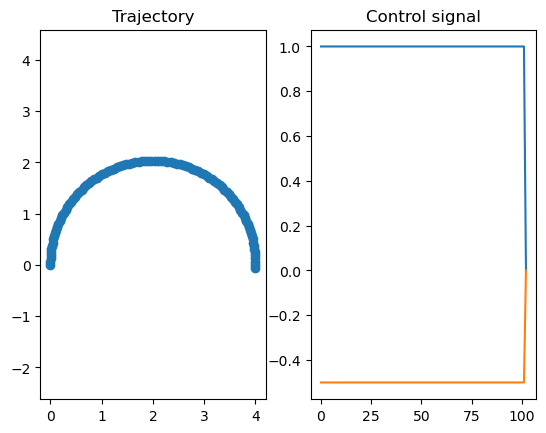

In [23]:
fig, axs = plt.subplots(1,2)
#Plotting the reference trajectory
axs[0].scatter(state_stack[:,0],state_stack[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(control_stack[:,0])
axs[1].set_title("Control signal")
axs[1].plot(control_stack[:,1], "tab:orange")

In [ ]:
optimal_path = np.array([0,0,math.pi])

for ii in np.linspace(0,2*math.pi,102):
    optimal_path = np.vstack((optimal_path, [4/(2*math.pi)*ii, 0, math.pi/2]))


optimal_path.shape

In [17]:
# define the objective function
# How many states are we really optimizing when we are using the 
# optimize function?
# Position and Control signal for sure!

def objective(x,y):
    #x: state vector
    #y: reference vector.
    #All objective functions in SciPy expect a numpy array
    #as their first argument which is to be optimized and must return
    #a float value.
    x = x.reshape(upstack.shape)
    x = x[:,[0,1,2]].flatten()
    #Other arguments can be provided.
    
    #Here is an implementation of the Quadratic Cost Function
    #J = ||S(t) - S_Ref(t)||^2
    return sum(abs(x - y)**2)

def consx(x):
    return [- x[i] + x[i-5] + dt*math.cos(x[i-3])*x[i-2] for i in range(5,len(x0)-5,5)]
def consy(x):
    return [- x[i+1] + x[i-4] + dt*math.sin(x[i-3])*x[i-2] for i in range(5,len(x0)-5,5)]
def const(x):
    return [- x[i+2] + x[i-3] + dt*x[i-1] for i in range(5,len(x0)-5,5)]

xnlc = NonlinearConstraint(consx,0,0)
ynlc = NonlinearConstraint(consy,0,0)
tnlc = NonlinearConstraint(const,0,0)

# eq_cons2 = [{'type':'eq', 
#         #Y
#         'fun': - x[i+1] + x[i-4] + dt*math.sin(x[i-3])*x[i-2]} for i in range(5,len(x0)-5,5)]
# eq_cons3 = [{'type':'eq', 
#         #Theta
#         'fun': - x[i+2] + x[i-3] + dt*x[i-1]} for i in range(5,len(x0)-5,5)]

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  | penalty  |CG stop|
|-------|-------|-------|-------------|----------|----------|----------|----------|-------|
|   1   |  516  |   0   | +5.7471e+02 | 1.00e+00 | 6.41e+00 | 2.22e-16 | 1.00e+00 |   0   |
|   2   | 1032  |   1   | +5.3710e+02 | 7.00e+00 | 6.08e+00 | 2.99e-04 | 1.00e+00 |   2   |
|   3   | 1548  |   2   | +3.2387e+02 | 4.90e+01 | 3.77e+00 | 1.40e-02 | 1.00e+00 |   2   |
|   4   | 2064  |   5   | +1.6044e+02 | 7.31e+01 | 1.31e+00 | 2.75e-02 | 1.00e+00 |   4   |
|   5   | 2580  |  10   | +1.3965e+02 | 7.31e+01 | 1.07e+00 | 5.38e-03 | 1.00e+00 |   4   |
|   6   | 3096  |  15   | +1.3441e+02 | 7.31e+01 | 8.72e-01 | 7.26e-04 | 1.00e+00 |   4   |
|   7   | 3612  |  20   | +1.2985e+02 | 7.31e+01 | 7.50e-01 | 5.34e-04 | 1.00e+00 |   4   |
|   8   | 4128  |  25   | +1.2607e+02 | 7.31e+01 | 6.78e-01 | 3.81e-04 | 1.00e+00 |   4   |
|   9   | 4644  |  30   | +1.2280e+02 | 7.31e+01 | 6.83e-01 | 2.93e-04 | 1.00e+0

|  89   | 45924 |  295  | +5.4330e+01 | 7.31e+01 | 1.81e-01 | 6.13e-06 | 1.00e+00 |   4   |
|  90   | 46440 |  298  | +5.4142e+01 | 7.31e+01 | 1.81e-01 | 6.17e-06 | 1.00e+00 |   4   |
|  91   | 46956 |  301  | +5.3955e+01 | 7.31e+01 | 1.81e-01 | 6.21e-06 | 1.00e+00 |   4   |
|  92   | 47472 |  304  | +5.3770e+01 | 7.31e+01 | 1.81e-01 | 6.24e-06 | 1.00e+00 |   4   |
|  93   | 47988 |  307  | +5.3587e+01 | 7.31e+01 | 1.81e-01 | 6.28e-06 | 1.00e+00 |   4   |
|  94   | 48504 |  310  | +5.3406e+01 | 7.31e+01 | 1.81e-01 | 6.32e-06 | 1.00e+00 |   4   |
|  95   | 49020 |  313  | +5.3227e+01 | 7.31e+01 | 1.81e-01 | 6.36e-06 | 1.00e+00 |   4   |
|  96   | 49536 |  316  | +5.3049e+01 | 7.31e+01 | 1.81e-01 | 6.40e-06 | 1.00e+00 |   4   |
|  97   | 50052 |  319  | +5.2873e+01 | 7.31e+01 | 1.80e-01 | 6.43e-06 | 1.00e+00 |   4   |
|  98   | 50568 |  322  | +5.2699e+01 | 7.31e+01 | 1.80e-01 | 6.45e-06 | 1.00e+00 |   4   |
|  99   | 51084 |  325  | +5.2527e+01 | 7.31e+01 | 1.80e-01 | 6.46e-06 | 1.00e+0

|  179  | 92364 |  565  | +4.3448e+01 | 7.31e+01 | 1.29e-01 | 2.89e-06 | 1.00e+00 |   4   |
|  180  | 92880 |  568  | +4.3377e+01 | 7.31e+01 | 1.29e-01 | 2.86e-06 | 1.00e+00 |   4   |
|  181  | 93396 |  571  | +4.3306e+01 | 7.31e+01 | 1.28e-01 | 2.82e-06 | 1.00e+00 |   4   |
|  182  | 93912 |  574  | +4.3236e+01 | 7.31e+01 | 1.28e-01 | 2.78e-06 | 1.00e+00 |   4   |
|  183  | 94428 |  577  | +4.3167e+01 | 7.31e+01 | 1.27e-01 | 2.74e-06 | 1.00e+00 |   4   |
|  184  | 94944 |  580  | +4.3098e+01 | 7.31e+01 | 1.27e-01 | 2.70e-06 | 1.00e+00 |   4   |
|  185  | 95460 |  583  | +4.3030e+01 | 7.31e+01 | 1.27e-01 | 2.68e-06 | 1.00e+00 |   4   |
|  186  | 95976 |  586  | +4.2962e+01 | 7.31e+01 | 1.26e-01 | 2.65e-06 | 1.00e+00 |   4   |
|  187  | 96492 |  589  | +4.2895e+01 | 7.31e+01 | 1.26e-01 | 2.62e-06 | 1.00e+00 |   4   |
|  188  | 97008 |  592  | +4.2829e+01 | 7.31e+01 | 1.25e-01 | 2.59e-06 | 1.00e+00 |   4   |
|  189  | 97524 |  595  | +4.2763e+01 | 7.31e+01 | 1.25e-01 | 2.57e-06 | 1.00e+0

|  269  |138804 |  818  | +3.8575e+01 | 7.31e+01 | 9.91e-02 | 1.51e-06 | 1.00e+00 |   4   |
|  270  |139320 |  820  | +3.8530e+01 | 7.31e+01 | 9.88e-02 | 1.50e-06 | 1.00e+00 |   4   |
|  271  |139836 |  822  | +3.8485e+01 | 7.31e+01 | 9.86e-02 | 1.50e-06 | 1.00e+00 |   4   |
|  272  |140352 |  824  | +3.8440e+01 | 7.31e+01 | 9.83e-02 | 1.49e-06 | 1.00e+00 |   4   |
|  273  |140868 |  826  | +3.8395e+01 | 7.31e+01 | 9.81e-02 | 1.49e-06 | 1.00e+00 |   4   |
|  274  |141384 |  828  | +3.8350e+01 | 7.31e+01 | 9.79e-02 | 1.48e-06 | 1.00e+00 |   4   |
|  275  |141900 |  830  | +3.8305e+01 | 7.31e+01 | 9.76e-02 | 1.47e-06 | 1.00e+00 |   4   |
|  276  |142416 |  832  | +3.8260e+01 | 7.31e+01 | 9.74e-02 | 1.47e-06 | 1.00e+00 |   4   |
|  277  |142932 |  834  | +3.8216e+01 | 7.31e+01 | 9.72e-02 | 1.46e-06 | 1.00e+00 |   4   |
|  278  |143448 |  836  | +3.8171e+01 | 7.31e+01 | 9.69e-02 | 1.45e-06 | 1.00e+00 |   4   |
|  279  |143964 |  838  | +3.8126e+01 | 7.31e+01 | 9.67e-02 | 1.45e-06 | 1.00e+0

|  359  |185244 |  998  | +3.4145e+01 | 7.31e+01 | 1.46e-01 | 2.55e-06 | 1.00e+00 |   4   |
|  360  |185760 | 1000  | +3.4085e+01 | 7.31e+01 | 1.47e-01 | 2.59e-06 | 1.00e+00 |   4   |
|  361  |186276 | 1002  | +3.4025e+01 | 7.31e+01 | 1.48e-01 | 2.64e-06 | 1.00e+00 |   4   |
|  362  |186792 | 1004  | +3.3964e+01 | 7.31e+01 | 1.49e-01 | 2.68e-06 | 1.00e+00 |   4   |
|  363  |187308 | 1006  | +3.3903e+01 | 7.31e+01 | 1.50e-01 | 2.73e-06 | 1.00e+00 |   4   |
|  364  |187824 | 1008  | +3.3841e+01 | 7.31e+01 | 1.51e-01 | 2.78e-06 | 1.00e+00 |   4   |
|  365  |188340 | 1010  | +3.3779e+01 | 7.31e+01 | 1.52e-01 | 2.82e-06 | 1.00e+00 |   4   |
|  366  |188856 | 1012  | +3.3717e+01 | 7.31e+01 | 1.53e-01 | 2.87e-06 | 1.00e+00 |   4   |
|  367  |189372 | 1014  | +3.3654e+01 | 7.31e+01 | 1.54e-01 | 2.92e-06 | 1.00e+00 |   4   |
|  368  |189888 | 1016  | +3.3592e+01 | 7.31e+01 | 1.55e-01 | 2.97e-06 | 1.00e+00 |   4   |
|  369  |190404 | 1018  | +3.3528e+01 | 7.31e+01 | 1.56e-01 | 3.02e-06 | 1.00e+0

|  449  |231684 | 1178  | +2.7807e+01 | 7.31e+01 | 1.52e-01 | 3.66e-06 | 1.00e+00 |   4   |
|  450  |232200 | 1180  | +2.7742e+01 | 7.31e+01 | 1.50e-01 | 3.60e-06 | 1.00e+00 |   4   |
|  451  |232716 | 1182  | +2.7676e+01 | 7.31e+01 | 1.49e-01 | 3.55e-06 | 1.00e+00 |   4   |
|  452  |233232 | 1184  | +2.7611e+01 | 7.31e+01 | 1.48e-01 | 3.49e-06 | 1.00e+00 |   4   |
|  453  |233748 | 1186  | +2.7547e+01 | 7.31e+01 | 1.46e-01 | 3.43e-06 | 1.00e+00 |   4   |
|  454  |234264 | 1188  | +2.7483e+01 | 7.31e+01 | 1.45e-01 | 3.37e-06 | 1.00e+00 |   4   |
|  455  |234780 | 1190  | +2.7420e+01 | 7.31e+01 | 1.43e-01 | 3.31e-06 | 1.00e+00 |   4   |
|  456  |235296 | 1192  | +2.7357e+01 | 7.31e+01 | 1.42e-01 | 3.25e-06 | 1.00e+00 |   4   |
|  457  |235812 | 1194  | +2.7295e+01 | 7.31e+01 | 1.40e-01 | 3.19e-06 | 1.00e+00 |   4   |
|  458  |236328 | 1196  | +2.7234e+01 | 7.31e+01 | 1.39e-01 | 3.13e-06 | 1.00e+00 |   4   |
|  459  |236844 | 1198  | +2.7172e+01 | 7.31e+01 | 1.38e-01 | 3.06e-06 | 1.00e+0

|  539  |278124 | 1358  | +2.3495e+01 | 7.31e+01 | 1.35e-01 | 3.07e-06 | 1.00e+00 |   4   |
|  540  |278640 | 1360  | +2.3456e+01 | 7.31e+01 | 1.35e-01 | 3.09e-06 | 1.00e+00 |   4   |
|  541  |279156 | 1362  | +2.3418e+01 | 7.31e+01 | 1.36e-01 | 3.11e-06 | 1.00e+00 |   4   |
|  542  |279672 | 1364  | +2.3379e+01 | 7.31e+01 | 1.36e-01 | 3.12e-06 | 1.00e+00 |   4   |
|  543  |280188 | 1366  | +2.3341e+01 | 7.31e+01 | 1.36e-01 | 3.13e-06 | 1.00e+00 |   4   |
|  544  |280704 | 1368  | +2.3303e+01 | 7.31e+01 | 1.37e-01 | 3.15e-06 | 1.00e+00 |   4   |
|  545  |281220 | 1370  | +2.3265e+01 | 7.31e+01 | 1.37e-01 | 3.16e-06 | 1.00e+00 |   4   |
|  546  |281736 | 1372  | +2.3226e+01 | 7.31e+01 | 1.37e-01 | 3.17e-06 | 1.00e+00 |   4   |
|  547  |282252 | 1374  | +2.3188e+01 | 7.31e+01 | 1.37e-01 | 3.18e-06 | 1.00e+00 |   4   |
|  548  |282768 | 1376  | +2.3150e+01 | 7.31e+01 | 1.38e-01 | 3.19e-06 | 1.00e+00 |   4   |
|  549  |283284 | 1378  | +2.3112e+01 | 7.31e+01 | 1.38e-01 | 3.20e-06 | 1.00e+0

|  629  |324564 | 1535  | +2.0558e+01 | 7.31e+01 | 1.07e-01 | 1.75e-06 | 1.00e+00 |   4   |
|  630  |325080 | 1536  | +2.0536e+01 | 7.31e+01 | 1.07e-01 | 1.72e-06 | 1.00e+00 |   4   |
|  631  |325596 | 1537  | +2.0514e+01 | 7.31e+01 | 1.06e-01 | 1.69e-06 | 1.00e+00 |   4   |
|  632  |326112 | 1538  | +2.0492e+01 | 7.31e+01 | 1.05e-01 | 1.66e-06 | 1.00e+00 |   4   |
|  633  |326628 | 1539  | +2.0470e+01 | 7.31e+01 | 1.04e-01 | 1.63e-06 | 1.00e+00 |   4   |
|  634  |327144 | 1540  | +2.0449e+01 | 7.31e+01 | 1.03e-01 | 1.60e-06 | 1.00e+00 |   4   |
|  635  |327660 | 1541  | +2.0428e+01 | 7.31e+01 | 1.02e-01 | 1.57e-06 | 1.00e+00 |   4   |
|  636  |328176 | 1542  | +2.0408e+01 | 7.31e+01 | 1.02e-01 | 1.54e-06 | 1.00e+00 |   4   |
|  637  |328692 | 1543  | +2.0387e+01 | 7.31e+01 | 1.01e-01 | 1.51e-06 | 1.00e+00 |   4   |
|  638  |329208 | 1544  | +2.0367e+01 | 7.31e+01 | 9.98e-02 | 1.48e-06 | 1.00e+00 |   4   |
|  639  |329724 | 1545  | +2.0347e+01 | 7.31e+01 | 9.90e-02 | 1.45e-06 | 1.00e+0

|  719  |371004 | 1625  | +1.9399e+01 | 7.31e+01 | 7.49e-02 | 2.03e-07 | 1.00e+00 |   4   |
|  720  |371520 | 1626  | +1.9392e+01 | 7.31e+01 | 7.49e-02 | 1.97e-07 | 1.00e+00 |   4   |
|  721  |372036 | 1627  | +1.9385e+01 | 7.31e+01 | 7.49e-02 | 1.92e-07 | 1.00e+00 |   4   |
|  722  |372552 | 1628  | +1.9379e+01 | 7.31e+01 | 7.49e-02 | 1.87e-07 | 1.00e+00 |   4   |
|  723  |373068 | 1629  | +1.9373e+01 | 7.31e+01 | 7.48e-02 | 1.82e-07 | 1.00e+00 |   4   |
|  724  |373584 | 1630  | +1.9366e+01 | 7.31e+01 | 7.48e-02 | 1.77e-07 | 1.00e+00 |   4   |
|  725  |374100 | 1631  | +1.9360e+01 | 7.31e+01 | 7.48e-02 | 1.73e-07 | 1.00e+00 |   4   |
|  726  |374616 | 1632  | +1.9354e+01 | 7.31e+01 | 7.48e-02 | 1.68e-07 | 1.00e+00 |   4   |
|  727  |375132 | 1633  | +1.9348e+01 | 7.31e+01 | 7.47e-02 | 1.64e-07 | 1.00e+00 |   4   |
|  728  |375648 | 1634  | +1.9342e+01 | 7.31e+01 | 7.47e-02 | 1.59e-07 | 1.00e+00 |   4   |
|  729  |376164 | 1635  | +1.9336e+01 | 7.31e+01 | 7.47e-02 | 1.55e-07 | 1.00e+0

|  809  |417444 | 1715  | +1.8979e+01 | 7.31e+01 | 7.26e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  810  |417960 | 1716  | +1.8975e+01 | 7.31e+01 | 7.26e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  811  |418476 | 1717  | +1.8972e+01 | 7.31e+01 | 7.25e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  812  |418992 | 1718  | +1.8968e+01 | 7.31e+01 | 7.25e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  813  |419508 | 1719  | +1.8964e+01 | 7.31e+01 | 7.25e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  814  |420024 | 1720  | +1.8961e+01 | 7.31e+01 | 7.24e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  815  |420540 | 1721  | +1.8957e+01 | 7.31e+01 | 7.24e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  816  |421056 | 1722  | +1.8954e+01 | 7.31e+01 | 7.24e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  817  |421572 | 1723  | +1.8950e+01 | 7.31e+01 | 7.24e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  818  |422088 | 1724  | +1.8947e+01 | 7.31e+01 | 7.23e-02 | 1.34e-07 | 1.00e+00 |   4   |
|  819  |422604 | 1725  | +1.8943e+01 | 7.31e+01 | 7.23e-02 | 1.34e-07 | 1.00e+0

|  899  |463884 | 2056  | +1.7337e+01 | 7.31e+01 | 2.70e-02 | 6.12e-07 | 1.00e+00 |   4   |
|  900  |464400 | 2065  | +1.7327e+01 | 7.31e+01 | 3.09e-02 | 2.62e-05 | 1.00e+00 |   4   |
|  901  |464916 | 2078  | +1.7268e+01 | 7.31e+01 | 3.83e-02 | 6.84e-04 | 1.00e+00 |   4   |
|  902  |465432 | 2081  | +1.7242e+01 | 7.31e+01 | 3.69e-02 | 4.63e-07 | 1.00e+00 |   4   |
|  903  |465948 | 2084  | +1.7234e+01 | 7.31e+01 | 3.51e-02 | 5.81e-07 | 1.00e+00 |   4   |
|  904  |466464 | 2087  | +1.7227e+01 | 7.31e+01 | 3.34e-02 | 4.82e-07 | 1.00e+00 |   4   |
|  905  |466980 | 2095  | +1.7210e+01 | 7.31e+01 | 3.64e-02 | 8.26e-05 | 1.00e+00 |   4   |
|  906  |467496 | 2098  | +1.7200e+01 | 7.31e+01 | 3.47e-02 | 4.52e-07 | 1.00e+00 |   4   |
|  907  |468012 | 2101  | +1.7193e+01 | 7.31e+01 | 3.32e-02 | 3.90e-07 | 1.00e+00 |   4   |
|  908  |468528 | 2104  | +1.7188e+01 | 7.31e+01 | 3.20e-02 | 3.48e-07 | 1.00e+00 |   4   |
|  909  |469044 | 2107  | +1.7183e+01 | 7.31e+01 | 3.10e-02 | 3.15e-07 | 1.00e+0

|  989  |510324 | 2329  | +1.6834e+01 | 7.31e+01 | 3.98e-02 | 5.37e-08 | 1.00e+00 |   4   |
|  990  |510840 | 2331  | +1.6831e+01 | 7.31e+01 | 3.96e-02 | 5.16e-08 | 1.00e+00 |   4   |
|  991  |511356 | 2333  | +1.6829e+01 | 7.31e+01 | 3.94e-02 | 4.96e-08 | 1.00e+00 |   4   |
|  992  |511872 | 2335  | +1.6826e+01 | 7.31e+01 | 3.92e-02 | 4.77e-08 | 1.00e+00 |   4   |
|  993  |512388 | 2337  | +1.6824e+01 | 7.31e+01 | 3.91e-02 | 4.60e-08 | 1.00e+00 |   4   |
|  994  |512904 | 2339  | +1.6821e+01 | 7.31e+01 | 3.89e-02 | 4.48e-08 | 1.00e+00 |   4   |
|  995  |513420 | 2349  | +1.6809e+01 | 7.31e+01 | 4.26e-02 | 8.84e-05 | 1.00e+00 |   4   |
|  996  |513936 | 2351  | +1.6803e+01 | 7.31e+01 | 4.24e-02 | 8.94e-08 | 1.00e+00 |   4   |
|  997  |514452 | 2353  | +1.6800e+01 | 7.31e+01 | 4.22e-02 | 8.78e-08 | 1.00e+00 |   4   |
|  998  |514968 | 2355  | +1.6797e+01 | 7.31e+01 | 4.20e-02 | 8.30e-08 | 1.00e+00 |   4   |
|  999  |515484 | 2357  | +1.6795e+01 | 7.31e+01 | 4.19e-02 | 7.82e-08 | 1.00e+0

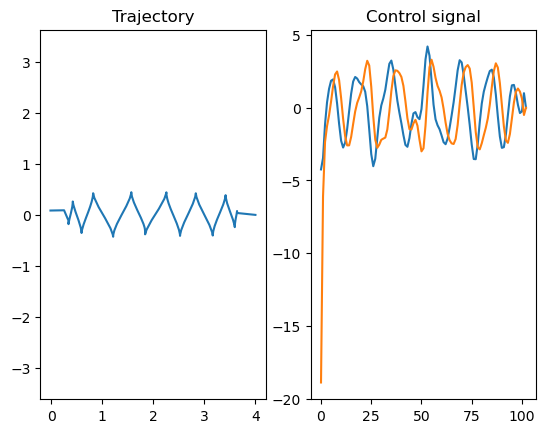

In [18]:
#Define y to be the reference path here. It is an additional argument
#to the optimize function
x0 = upstack.flatten()

res = minimize(objective, x0, args=(optimal_path.flatten()),method='trust-constr', constraints= [xnlc,ynlc,tnlc], options={'verbose':3})
sol = res.x.reshape(upstack.shape)

fig, axs = plt.subplots(1,2)
#Plotting the trajectory
axs[0].plot(sol[:,0],sol[:,1])
axs[0].axis("equal")
axs[0].set_title("Trajectory")

#Plotting the control signal 
axs[1].plot(sol[:,3])
axs[1].set_title("Control signal")
axs[1].plot(sol[:,4], "tab:orange")

In [ ]:
sol[102]

In [ ]:
z = [1,2,3,4,5,6,7,8,9,10] #arbitrary list elements that we need

def f(x0):
    #Counter variables. Start at the first state.
    i = 5
    
    for j in range(5,len(x0)+5,5):
        print(j)
        

    
    
z1 = np.asarray(z[5:]) 
z2 = np.asarray(z[:-5])

In [ ]:
f(x0)